In [12]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 

In [13]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.
        Parameters:
        - hr_images (numpy array): High-resolution images of shape (N, 1, 128, 128).
        - lr_images (numpy array): Low-resolution images of shape (N, 1, 64, 64).
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = torch.from_numpy(self.normalize(hr_images))
        self.lr_images = torch.from_numpy(self.normalize(lr_images))
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        """
        Get the interpolated low-resolution image and high-resolution image at the specified index.
        Parameters:
        - idx (int): Index of the image to retrieve.
        Returns:
        - tuple of torch.Tensor: Interpolated low-resolution image and high-resolution image.
        """
        hr = self.hr_images[idx]
        lr = self.lr_images[idx]
        
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr.unsqueeze(0), size=(150, 150), mode='bilinear', align_corners=False)
        
        return lr_interpolated.squeeze(0), hr

    @staticmethod
    def normalize(x):
        """
        Normalize the images to [0, 1] range.
        """
        return (x - np.min(x)) / (np.max(x) - np.min(x))

In [14]:
X_train_HR = np.load('./A_HR_train.npy').astype(np.float32) 
X_train_LR = np.load('./A_LR_train.npy').astype(np.float32)
print(X_train_HR.shape)
print(X_train_LR.shape)

(8100, 1, 150, 150)
(8100, 1, 75, 75)


In [15]:
X_val_HR = np.load('./A_HR_val.npy').astype(np.float32)
X_val_LR = np.load('./A_LR_val.npy').astype(np.float32)
print(X_val_HR.shape)
print(X_val_LR.shape)

(1000, 1, 150, 150)
(1000, 1, 75, 75)


In [16]:
X_test_HR = np.load('./A_HR_test.npy').astype(np.float32)
X_test_LR = np.load('./A_LR_test.npy').astype(np.float32)
print(X_test_HR.shape)
print(X_test_LR.shape)

(900, 1, 150, 150)
(900, 1, 75, 75)


In [ ]:

# Import required libraries
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
batch_size = 20
train_dataset = SuperresDataset(X_train_HR,X_train_LR)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = SuperresDataset( X_val_HR,X_val_LR)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [46]:
test_dataset = SuperresDataset( X_test_HR,X_test_LR)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [18]:
dataiter = iter(train_dataloader)
batch = next(dataiter)

hr_images = batch[1]
min_val = hr_images.min().item()
max_val = hr_images.max().item()

print(f"Min value: {min_val}, Max value: {max_val}")

Min value: 0.0, Max value: 1.0


In [24]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out

class Generator(nn.Module):
    def __init__(self, num_channels=1, num_blocks=8,lr_size=16):
        super(Generator, self).__init__()
        
        self.conv1 = nn.Conv2d(num_channels, lr_size, kernel_size=9, padding=4)
        self.relu = nn.ReLU(inplace=True)
        
        res_blocks = [ResidualBlock(lr_size) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*res_blocks)
        
        self.conv2 = nn.Conv2d(lr_size, lr_size, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(lr_size)
        
        self.conv3 = nn.Conv2d(lr_size, num_channels, kernel_size=9, padding=4)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        residual = x
        x = self.res_blocks(x)
        x = self.bn2(self.conv2(x))
        x += residual
        x = self.conv3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, num_channels=1):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.BatchNorm2d(out_channels),
            )
        
        self.model = nn.Sequential(
            discriminator_block(num_channels, 16, 1),
            discriminator_block(16, 16, 2),
            discriminator_block(16, 32, 1),
            discriminator_block(32, 32, 2),
            discriminator_block(32, 64, 1),
            discriminator_block(64, 64, 2),
            discriminator_block(64, 128, 1),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(128, 256, kernel_size=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.model(x).view(batch_size))

In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import os
D_loss=[]
G_loss=[]
tot_loss=[]
def train_srgan(generator, discriminator, train_loader, content_criterion, adversarial_criterion, 
                gen_optimizer, disc_optimizer, scheduler, device, num_epochs=30, save_dir='./Model'):
    generator.to(device)
    discriminator.to(device)
    
    best_total_loss = float('inf') 
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        
        running_g_loss = 0.0
        running_d_loss = 0.0
        total_batches = len(train_loader)
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        
        for data in pbar:
            lr, hr = data[0].to(device), data[1].to(device)
          
            # Train Discriminator
            disc_optimizer.zero_grad()
            
            sr = generator(lr)
            real_output = discriminator(hr)
            fake_output = discriminator(sr.detach())
            
            d_loss_real = adversarial_criterion(real_output, torch.ones_like(real_output))
            d_loss_fake = adversarial_criterion(fake_output, torch.zeros_like(fake_output))
            d_loss = d_loss_real + d_loss_fake
            
            d_loss.backward()
            disc_optimizer.step()
            
            # Train Generator
            gen_optimizer.zero_grad()
            
            sr = generator(lr)
            fake_output = discriminator(sr)
            
            content_loss = content_criterion(sr, hr)
            adversarial_loss = adversarial_criterion(fake_output, torch.ones_like(fake_output))
            g_loss = content_loss + 1e-3 * adversarial_loss  # The factor 1e-3 balances the two losses
            
            g_loss.backward()
            gen_optimizer.step()
            
            running_g_loss += g_loss.item()
            running_d_loss += d_loss.item()
            
            pbar.set_postfix({'G_loss': f'{g_loss.item():.8f}', 'D_loss': f'{d_loss.item():.8f}'})
        
        # Step the scheduler after each epoch
        scheduler.step()
        
        # Calculate average losses for the epoch
        epoch_g_loss = running_g_loss / total_batches
        epoch_d_loss = running_d_loss / total_batches
        epoch_total_loss = epoch_g_loss + epoch_d_loss
        D_loss.append(epoch_d_loss)
        G_loss.append(epoch_g_loss)
        tot_loss.append(epoch_total_loss)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, G_Loss: {epoch_g_loss:.8f}, D_Loss: {epoch_d_loss:.8f}, Total Loss: {epoch_total_loss:.8f}')
        
        # Save the best model based on total loss
        if epoch_total_loss < best_total_loss:
            best_total_loss = epoch_total_loss
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'gen_optimizer_state_dict': gen_optimizer.state_dict(),
                'disc_optimizer_state_dict': disc_optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'g_loss': epoch_g_loss,
                'd_loss': epoch_d_loss,
                'total_loss': epoch_total_loss,
            }, os.path.join(save_dir, 'best_model.pth'))
            print(f'New best model saved with Total Loss: {epoch_total_loss:.8f}')
    
    print('Finished Training')


In [26]:
from torchsummary import summary
generator = Generator(num_channels=1).to('cuda')  
discriminator = Discriminator(num_channels=1).to('cuda') 
summary(generator,(1,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]           1,312
              ReLU-2         [-1, 16, 150, 150]               0
            Conv2d-3         [-1, 16, 150, 150]           2,320
       BatchNorm2d-4         [-1, 16, 150, 150]              32
              ReLU-5         [-1, 16, 150, 150]               0
            Conv2d-6         [-1, 16, 150, 150]           2,320
       BatchNorm2d-7         [-1, 16, 150, 150]              32
     ResidualBlock-8         [-1, 16, 150, 150]               0
            Conv2d-9         [-1, 16, 150, 150]           2,320
      BatchNorm2d-10         [-1, 16, 150, 150]              32
             ReLU-11         [-1, 16, 150, 150]               0
           Conv2d-12         [-1, 16, 150, 150]           2,320
      BatchNorm2d-13         [-1, 16, 150, 150]              32
    ResidualBlock-14         [-1, 16, 1

In [27]:
summary(discriminator ,(1,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             160
         LeakyReLU-2         [-1, 16, 150, 150]               0
       BatchNorm2d-3         [-1, 16, 150, 150]              32
            Conv2d-4           [-1, 16, 75, 75]           2,320
         LeakyReLU-5           [-1, 16, 75, 75]               0
       BatchNorm2d-6           [-1, 16, 75, 75]              32
            Conv2d-7           [-1, 32, 75, 75]           4,640
         LeakyReLU-8           [-1, 32, 75, 75]               0
       BatchNorm2d-9           [-1, 32, 75, 75]              64
           Conv2d-10           [-1, 32, 38, 38]           9,248
        LeakyReLU-11           [-1, 32, 38, 38]               0
      BatchNorm2d-12           [-1, 32, 38, 38]              64
           Conv2d-13           [-1, 64, 38, 38]          18,496
        LeakyReLU-14           [-1, 64,

In [37]:
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.nn.parallel import DataParallel



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


generator = Generator(num_channels=1)  
discriminator = Discriminator(num_channels=1) 


if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    generator = DataParallel(generator)
    discriminator = DataParallel(discriminator)

generator = generator.to(device)
discriminator = discriminator.to(device)


content_criterion = nn.L1Loss().to(device)
adversarial_criterion = nn.BCELoss().to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)


scheduler = StepLR(gen_optimizer, step_size=10, gamma=0.5)
train_srgan(generator, discriminator, train_dataloader, content_criterion, adversarial_criterion, 
            gen_optimizer, disc_optimizer, scheduler, device)

Using device: cuda


Epoch 1/60, G_Loss: 0.01858462, D_Loss: 0.58634635, Total Loss: 0.60493097
New best model saved with Total Loss: 0.60493097


Epoch 2/60, G_Loss: 0.01283695, D_Loss: 0.16935444, Total Loss: 0.18219139
New best model saved with Total Loss: 0.18219139


Epoch 3/60, G_Loss: 0.01337112, D_Loss: 0.05446278, Total Loss: 0.06783389
New best model saved with Total Loss: 0.06783389


Epoch 4/60, G_Loss: 0.01258470, D_Loss: 0.47190597, Total Loss: 0.48449067


Epoch 5/60, G_Loss: 0.01117125, D_Loss: 0.51888932, Total Loss: 0.53006058


Epoch 6/60, G_Loss: 0.01084579, D_Loss: 0.06496059, Total Loss: 0.07580638


Epoch 7/60, G_Loss: 0.01157794, D_Loss: 0.04481641, Total Loss: 0.05639436
New best model saved with Total Loss: 0.05639436


Epoch 8/60, G_Loss: 0.01176219, D_Loss: 0.03180677, Total Loss: 0.04356896
New best model saved with Total Loss: 0.04356896


Epoch 9/60, G_Loss: 0.01228038, D_Loss: 0.03446077, Total Loss: 0.04674115


Epoch 10/60, G_Loss: 0.01228105, D_Loss: 0.03845270, Total Loss: 0.05073376


Epoch 11/60, G_Loss: 0.01173643, D_Loss: 0.01646028, Total Loss: 0.02819671
New best model saved with Total Loss: 0.02819671


Epoch 12/60, G_Loss: 0.01192279, D_Loss: 0.01216567, Total Loss: 0.02408846
New best model saved with Total Loss: 0.02408846


Epoch 13/60, G_Loss: 0.01220283, D_Loss: 0.01233317, Total Loss: 0.02453599


Epoch 14/60, G_Loss: 0.01254965, D_Loss: 0.00828676, Total Loss: 0.02083641
New best model saved with Total Loss: 0.02083641


Epoch 15/60, G_Loss: 0.01305928, D_Loss: 0.00769406, Total Loss: 0.02075334
New best model saved with Total Loss: 0.02075334


Epoch 16/60, G_Loss: 0.01281819, D_Loss: 0.01707615, Total Loss: 0.02989434


Epoch 17/60, G_Loss: 0.01233935, D_Loss: 0.11995447, Total Loss: 0.13229381


Epoch 18/60, G_Loss: 0.01196338, D_Loss: 0.00880579, Total Loss: 0.02076917


Epoch 19/60, G_Loss: 0.01306703, D_Loss: 0.03840355, Total Loss: 0.05147058


Epoch 20/60, G_Loss: 0.01300048, D_Loss: 0.00597589, Total Loss: 0.01897637
New best model saved with Total Loss: 0.01897637


Epoch 21/60, G_Loss: 0.01312888, D_Loss: 0.08690997, Total Loss: 0.10003885


Epoch 22/60, G_Loss: 0.01129243, D_Loss: 0.39989411, Total Loss: 0.41118654


Epoch 23/60, G_Loss: 0.01154910, D_Loss: 0.30452107, Total Loss: 0.31607018


Epoch 24/60, G_Loss: 0.01158448, D_Loss: 0.35157028, Total Loss: 0.36315477


Epoch 25/60, G_Loss: 0.01143953, D_Loss: 0.38943289, Total Loss: 0.40087242


Epoch 26/60, G_Loss: 0.01129847, D_Loss: 0.38763771, Total Loss: 0.39893618


Epoch 27/60, G_Loss: 0.01107150, D_Loss: 0.46595379, Total Loss: 0.47702529


Epoch 28/60, G_Loss: 0.01083422, D_Loss: 0.53793679, Total Loss: 0.54877101


Epoch 29/60, G_Loss: 0.01072951, D_Loss: 0.48763729, Total Loss: 0.49836680


Epoch 30/60, G_Loss: 0.01126914, D_Loss: 0.39799065, Total Loss: 0.40925979


Epoch 31/60, G_Loss: 0.01112427, D_Loss: 0.44950180, Total Loss: 0.46062607


Epoch 32/60, G_Loss: 0.01125917, D_Loss: 0.36573544, Total Loss: 0.37699461


Epoch 33/60, G_Loss: 0.01127927, D_Loss: 0.37955947, Total Loss: 0.39083873


Epoch 34/60, G_Loss: 0.01132399, D_Loss: 0.36379652, Total Loss: 0.37512051


Epoch 35/60, G_Loss: 0.01148446, D_Loss: 0.37368249, Total Loss: 0.38516695


Epoch 36/60, G_Loss: 0.01127274, D_Loss: 0.42841365, Total Loss: 0.43968639


Epoch 37/60, G_Loss: 0.01125957, D_Loss: 0.42405419, Total Loss: 0.43531376


Epoch 38/60, G_Loss: 0.01131965, D_Loss: 0.38646670, Total Loss: 0.39778635


Epoch 39/60, G_Loss: 0.01141973, D_Loss: 0.36377095, Total Loss: 0.37519067


Epoch 40/60, G_Loss: 0.01152418, D_Loss: 0.37761646, Total Loss: 0.38914063


Epoch 41/60, G_Loss: 0.01115936, D_Loss: 0.45562706, Total Loss: 0.46678643


Epoch 42/60, G_Loss: 0.01136402, D_Loss: 0.32331844, Total Loss: 0.33468246


Epoch 43/60, G_Loss: 0.01155047, D_Loss: 0.30766710, Total Loss: 0.31921758


Epoch 44/60, G_Loss: 0.01179899, D_Loss: 0.26128256, Total Loss: 0.27308155


Epoch 45/60, G_Loss: 0.01218085, D_Loss: 0.24144045, Total Loss: 0.25362130


Epoch 46/60, G_Loss: 0.01238414, D_Loss: 0.27017708, Total Loss: 0.28256122


Epoch 47/60, G_Loss: 0.01233121, D_Loss: 0.34045645, Total Loss: 0.35278765


Epoch 48/60, G_Loss: 0.01217260, D_Loss: 0.30648578, Total Loss: 0.31865838


Epoch 49/60, G_Loss: 0.01213791, D_Loss: 0.31005596, Total Loss: 0.32219387


Epoch 50/60, G_Loss: 0.01203974, D_Loss: 0.31487292, Total Loss: 0.32691266


Epoch 51/60, G_Loss: 0.01206458, D_Loss: 0.27361405, Total Loss: 0.28567863


Epoch 52/60, G_Loss: 0.01229322, D_Loss: 0.25791909, Total Loss: 0.27021231


Epoch 53/60, G_Loss: 0.01254283, D_Loss: 0.20180448, Total Loss: 0.21434731


Epoch 54/60, G_Loss: 0.01272152, D_Loss: 0.20081200, Total Loss: 0.21353352


Epoch 55/60, G_Loss: 0.01268541, D_Loss: 0.23481029, Total Loss: 0.24749570


Epoch 56/60, G_Loss: 0.01267907, D_Loss: 0.25566366, Total Loss: 0.26834273


Epoch 57/60, G_Loss: 0.01282336, D_Loss: 0.16710959, Total Loss: 0.17993295


Epoch 58/60, G_Loss: 0.01310742, D_Loss: 0.13982667, Total Loss: 0.15293409


Epoch 59/60, G_Loss: 0.01323592, D_Loss: 0.16736312, Total Loss: 0.18059904


Epoch 60/60, G_Loss: 0.01331414, D_Loss: 0.12996156, Total Loss: 0.14327570
Finished Training


In [39]:
save_path = "./Model/Generator.pth"
torch.save(generator.state_dict(), save_path)
print("Saved Successfully")

Saved Successfully


In [40]:
save_path = "./Model/Discriminator.pth"
torch.save(discriminator.state_dict(), save_path)
print("Saved Successfully")

Saved Successfully


In [42]:
import torch

def load_srgan_model(generator, discriminator, gen_optimizer, disc_optimizer, scheduler, device, model_path):
    checkpoint = torch.load(model_path, map_location=device)
    
    # Function to remove 'module.' prefix if it exists
    def remove_module_prefix(state_dict):
        return {k.replace('module.', ''): v for k, v in state_dict.items()}

    # Load generator state dict
    gen_state_dict = remove_module_prefix(checkpoint['generator_state_dict'])
    generator.load_state_dict(gen_state_dict)

    # Load discriminator state dict
    disc_state_dict = remove_module_prefix(checkpoint['discriminator_state_dict'])
    discriminator.load_state_dict(disc_state_dict)
    
    gen_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
    disc_optimizer.load_state_dict(checkpoint['disc_optimizer_state_dict'])
    
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    epoch = checkpoint['epoch']
    g_loss = checkpoint['g_loss']
    d_loss = checkpoint['d_loss']
    total_loss = checkpoint['total_loss']
    
    print(f"Loaded model from epoch {epoch}")
    print(f"Generator Loss: {g_loss:.8f}")
    print(f"Discriminator Loss: {d_loss:.8f}")
    print(f"Total Loss: {total_loss:.8f}")
    
    return generator, discriminator, gen_optimizer, disc_optimizer, scheduler, epoch

# Usage example:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00001)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(gen_optimizer, step_size=10, gamma=0.5)

model_path = './Model/best_model.pth'
generator, discriminator, gen_optimizer, disc_optimizer, scheduler, epoch = load_srgan_model(
    generator, discriminator, gen_optimizer, disc_optimizer, scheduler, device, model_path
)

/tmp/ipykernel_192594/3441606952.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Loaded model from epoch 19
Generator Loss: 0.01300048
Discriminator Loss: 0.00597589
Total Loss: 0.01897637


In [ ]:
train_srgan(generator, discriminator, train_dataloader, content_criterion, adversarial_criterion, 
            gen_optimizer, disc_optimizer, scheduler, device)

Epoch 1/30, G_Loss: 0.00827179, D_Loss: 0.00237070, Total Loss: 0.01064249
New best model saved with Total Loss: 0.01064249


Epoch 2/30, G_Loss: 0.00816800, D_Loss: 0.00321377, Total Loss: 0.01138177


Epoch 3/30, G_Loss: 0.00831172, D_Loss: 0.00168830, Total Loss: 0.01000002
New best model saved with Total Loss: 0.01000002


Epoch 4/30, G_Loss: 0.00833151, D_Loss: 0.00196013, Total Loss: 0.01029164


Epoch 5/30, G_Loss: 0.00893983, D_Loss: 0.00306464, Total Loss: 0.01200447


Epoch 6/30, G_Loss: 0.00939993, D_Loss: 0.00071642, Total Loss: 0.01011636


Epoch 7/30, G_Loss: 0.00978985, D_Loss: 0.00037812, Total Loss: 0.01016797


Epoch 8/30, G_Loss: 0.00969979, D_Loss: 0.00037031, Total Loss: 0.01007010


Epoch 9/30, G_Loss: 0.00970745, D_Loss: 0.00035015, Total Loss: 0.01005760


Epoch 10/30, G_Loss: 0.00982487, D_Loss: 0.00026822, Total Loss: 0.01009310


Epoch 11/30, G_Loss: 0.00987611, D_Loss: 0.00028551, Total Loss: 0.01016162


Epoch 12/30, G_Loss: 0.00997840, D_Loss: 0.00029933, Total Loss: 0.01027773


Epoch 13/30, G_Loss: 0.01014517, D_Loss: 0.00029240, Total Loss: 0.01043757


Epoch 14/30, G_Loss: 0.01179651, D_Loss: 0.00080243, Total Loss: 0.01259894


Epoch 15/30, G_Loss: 0.01139460, D_Loss: 0.00177022, Total Loss: 0.01316481


Epoch 16/30, G_Loss: 0.01030647, D_Loss: 0.02788146, Total Loss: 0.03818794


Epoch 17/30, G_Loss: 0.00955144, D_Loss: 0.00753848, Total Loss: 0.01708992


Epoch 18/30, G_Loss: 0.00987119, D_Loss: 0.00314483, Total Loss: 0.01301601


Epoch 19/30, G_Loss: 0.01010198, D_Loss: 0.00120116, Total Loss: 0.01130314


Epoch 20/30, G_Loss: 0.01022251, D_Loss: 0.03957902, Total Loss: 0.04980153


Epoch 21/30, G_Loss: 0.01041608, D_Loss: 0.01936132, Total Loss: 0.02977740


Epoch 22/30, G_Loss: 0.01062573, D_Loss: 0.00599392, Total Loss: 0.01661965


Epoch 23/30, G_Loss: 0.01200226, D_Loss: 0.00235176, Total Loss: 0.01435403


Epoch 24/30, G_Loss: 0.01019932, D_Loss: 0.00124707, Total Loss: 0.01144640


Epoch 25/30, G_Loss: 0.01027452, D_Loss: 0.00062287, Total Loss: 0.01089739


Epoch 26/30, G_Loss: 0.01039485, D_Loss: 0.00031709, Total Loss: 0.01071195


Epoch 27/30, G_Loss: 0.01033146, D_Loss: 0.00025908, Total Loss: 0.01059054


Epoch 28/30, G_Loss: 0.01045564, D_Loss: 0.00028231, Total Loss: 0.01073795


Epoch 29/30, G_Loss: 0.01075757, D_Loss: 0.00012926, Total Loss: 0.01088682


Epoch 30/30, G_Loss: 0.01104510, D_Loss: 0.01695203, Total Loss: 0.02799713
Finished Training


In [44]:
!pip install pytorch_msssim

Defaulting to user installation because normal site-packages is not writeable


In [47]:
import torch
import torch.nn as nn
from tqdm import tqdm
from pytorch_msssim import ssim
import math

def evaluate_generator(generator, test_loader, device):
    generator.eval()
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()
    
    psnr_scores = []
    ssim_scores = []
    mse_scores = []
    l1_scores = []
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating Generator"):
            lr, hr = data[0].to(device), data[1].to(device)
            sr = generator(lr)
            
            # Ensure sr and hr have the same size
            if sr.size() != hr.size():
                sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
            
            # Calculate metrics for each image in the batch
            for i in range(sr.size(0)):
                sr_img = sr[i].unsqueeze(0)
                hr_img = hr[i].unsqueeze(0)
                
                # MSE
                mse = mse_criterion(sr_img, hr_img).item()
                mse_scores.append(mse)
                
                # PSNR
                psnr = 10 * math.log10(1 / mse)
                psnr_scores.append(psnr)
                
                # SSIM
                ssim_score = ssim(sr_img, hr_img, data_range=1.0, size_average=False).item()
                ssim_scores.append(ssim_score)
                
                # L1 Loss
                l1_loss = l1_criterion(sr_img, hr_img).item()
                l1_scores.append(l1_loss)
    
    # Calculate average scores
    avg_psnr = sum(psnr_scores) / len(psnr_scores)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)
    avg_mse = sum(mse_scores) / len(mse_scores)
    avg_l1 = sum(l1_scores) / len(l1_scores)
    
    return {
        'psnr': psnr_scores,
        'ssim': ssim_scores,
        'mse': mse_scores,
        'l1': l1_scores,
        'avg_psnr': avg_psnr,
        'avg_ssim': avg_ssim,
        'avg_mse': avg_mse,
        'avg_l1': avg_l1
    }


results = evaluate_generator(generator, test_dataloader, device)

print(f"Average PSNR: {results['avg_psnr']:.2f}")
print(f"Average SSIM: {results['avg_ssim']:.4f}")
print(f"Average MSE: {results['avg_mse']:.6f}")
print(f"Average L1 Loss: {results['avg_l1']:.6f}")

Evaluating Generator: 100%|██████████| 45/45 [00:02<00:00, 16.59it/s]


Average PSNR: 39.94
Average SSIM: 0.9634
Average MSE: 0.000103
Average L1 Loss: 0.006155


In [ ]:
print(f"Average PSNR: {results['avg_psnr']:.2f}")
print(f"Average SSIM: {results['avg_ssim']:.4f}")
print(f"Average MSE: {results['avg_mse']:.6f}")
print(f"Average L1 Loss: {results['avg_l1']:.6f}")

Average PSNR: 26.52
Average SSIM: 0.5664
Average MSE: 0.002784
Average L1 Loss: 0.044891


Input shape (lr): torch.Size([20, 1, 150, 150])
Ground truth shape (hr): torch.Size([20, 1, 150, 150])
Model output shape (sr): torch.Size([20, 1, 150, 150])
Resized model output shape (sr): torch.Size([20, 1, 150, 150])


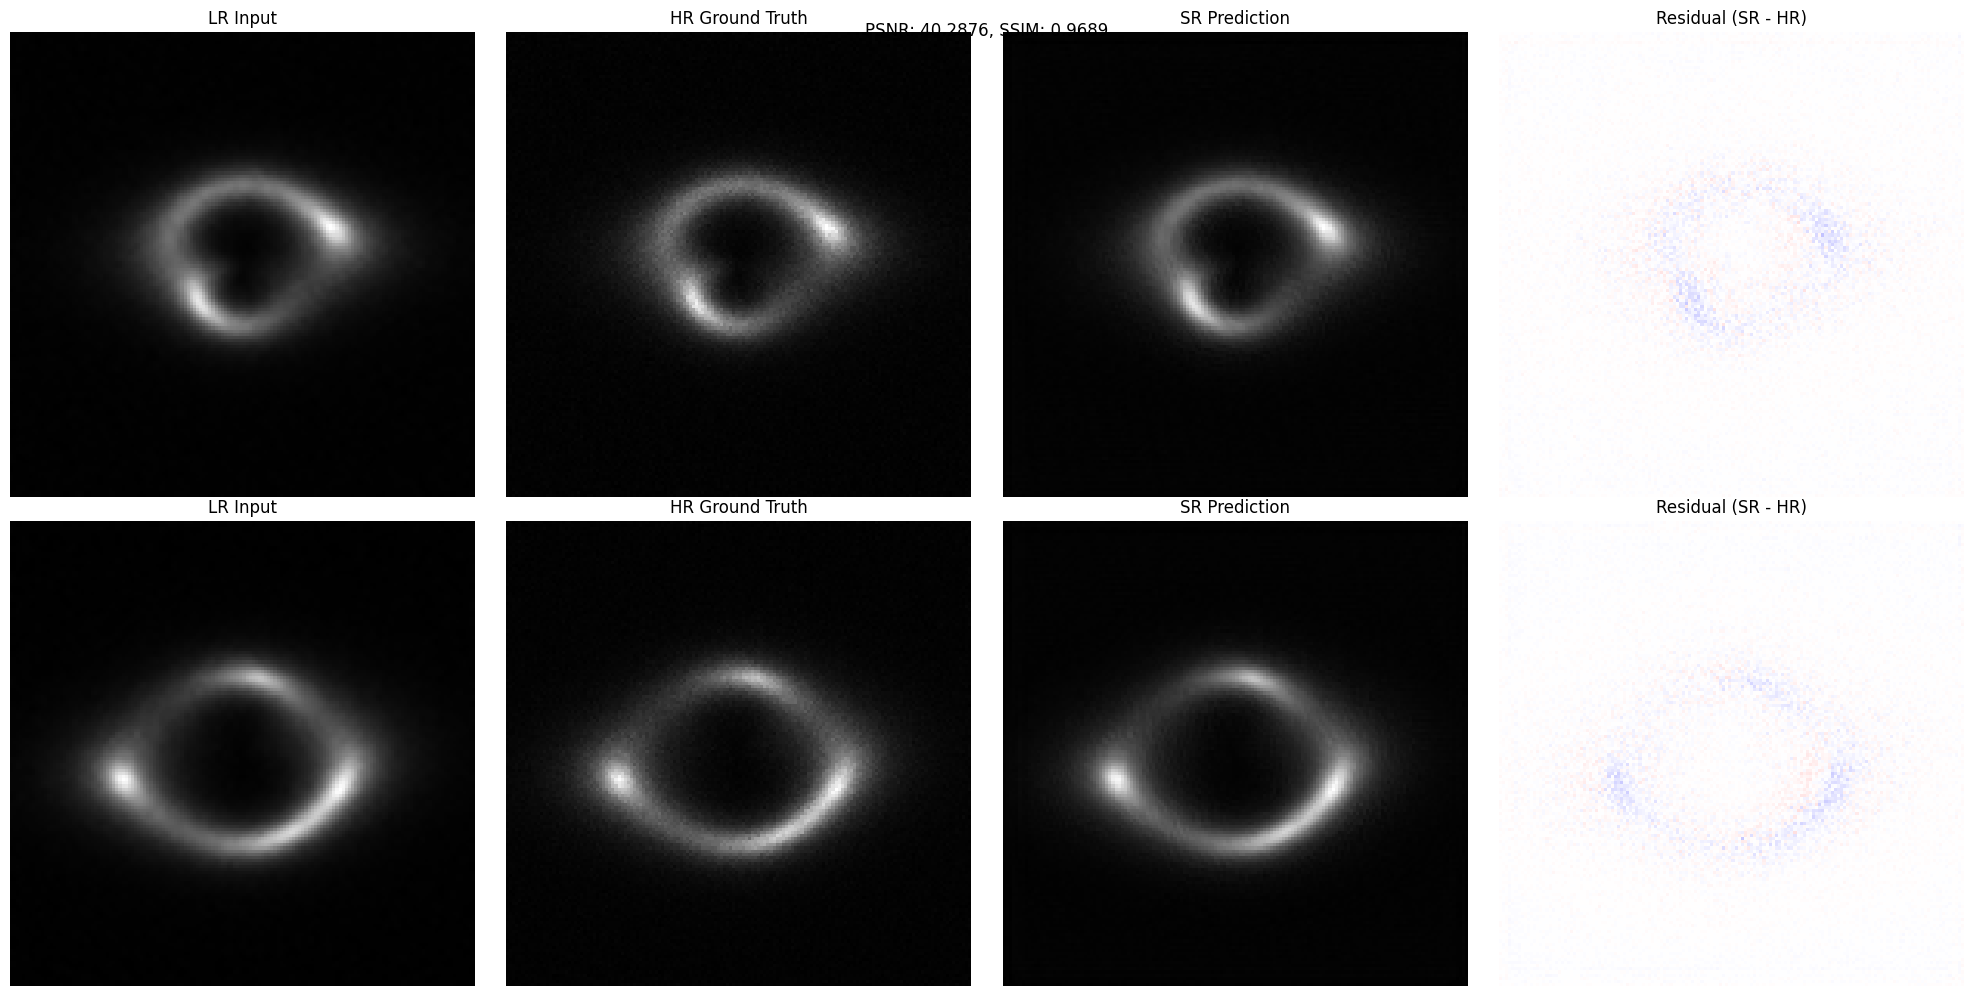

In [50]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def norma(x):
    return (x - x.min()) / (x.max() - x.min())

def plot_samples(model, test_loader, device, num_samples=2):
    model.eval()
    
    # Get a batch of images
    lr, hr = next(iter(test_loader))
    lr, hr = lr.to(device), hr.to(device)
    
    print(f"Input shape (lr): {lr.shape}")
    print(f"Ground truth shape (hr): {hr.shape}")
    
    with torch.no_grad():
        sr = model(lr)
    
    print(f"Model output shape (sr): {sr.shape}")
    
    # Ensure sr and hr have the same size
    if sr.size() != hr.size():
        sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
    
    print(f"Resized model output shape (sr): {sr.shape}")
    
    # Determine the number of samples to plot (minimum of batch size and num_samples)
    num_samples = min(lr.size(0), num_samples)
    
    # Calculate residuals
    residuals = hr - sr
    
    # Calculate metrics
    batch_psnr = []
    batch_ssim = []
    for i in range(num_samples):
        sr_np = norma(sr[i, 0].cpu().numpy())
        hr_np = norma(hr[i, 0].cpu().numpy())
        batch_psnr.append(psnr(hr_np, sr_np, data_range=1.0))
        batch_ssim.append(ssim(hr_np, sr_np, data_range=1.0))
    
    avg_psnr = np.mean(batch_psnr)
    avg_ssim = np.mean(batch_ssim)
    
    # Plot the images
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    # Ensure axes is always 2D, even when num_samples is 1
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # LR image
        axes[i, 0].imshow(lr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('LR Input')
        axes[i, 0].axis('off')
        # HR image
        axes[i, 1].imshow(hr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('HR Ground Truth')
        axes[i, 1].axis('off')
        # SR prediction
        axes[i, 2].imshow(sr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 2].set_title('SR Prediction')
        axes[i, 2].axis('off')
        # Residual map
        axes[i, 3].imshow(residuals[i, 0].cpu().numpy(), cmap='bwr', vmin=-0.5, vmax=0.5)
        axes[i, 3].set_title('Residual (SR - HR)')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}')
    plt.show()

# Usage
plot_samples(generator, test_dataloader, device, num_samples=2)  # Requesting 10 samples
